# Trying to figure out what the prior should be. 

In this notebook I will first explore how sensitive the results are to the prior by testing how the velocity distributions change with four priors:

1. An uninformative prior.
2. A prior constructed from the brightest stars.
3. A prior constructed from the faintest stars.
4. A prior constructed from all stars.

These priors need to be created using robust estimates of the mean and covariance of velocities, so I'll need to sigma clip to calculate those.

I also need to check that it does actually make sense to have a multivariate Gaussian prior that includes distance.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import aviary as av
import astropy.stats as aps
import starspot as ss

plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 15,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load velocity file.

In [18]:
df = pd.read_csv("../../aviary/mc_san_gaia_lam.csv")

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Which RVs are better? Gaia or Lamost? -- Gaia.

4.70974
10009 stars with lamost RVs. Median uncert =  4.70974
3587 stars with gaia RVs. Median uncert =  1.8760283253525023


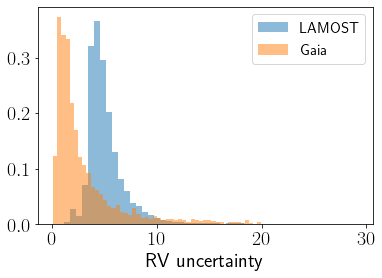

In [37]:
plt.hist(df.e_RV_lam[(df.e_RV_lam < 30) * (.1 < df.e_RV_lam)], 50, density=True, alpha=.5, label="LAMOST");
print(np.median(df.e_RV_lam.values[np.isfinite(df.e_RV_lam.values)]))

plt.hist(df.radial_velocity_error.values, 50, density=True, alpha=.5, label="Gaia");
plt.legend();
plt.xlabel("RV uncertainty");

print(len(df.e_RV_lam[(df.e_RV_lam < 30) * (.1 < df.e_RV_lam)]), "stars with lamost RVs. Median uncert = ",
     np.median(df.e_RV_lam[(df.e_RV_lam < 30) * (.1 < df.e_RV_lam)]))
print(len(df.radial_velocity_error.values[np.isfinite(df.radial_velocity_error.values)]), "stars with gaia RVs. Median uncert = ",
     np.median(df.radial_velocity_error.values[np.isfinite(df.radial_velocity_error.values)]))

In [20]:
vx, vy, vz = df.vx.values, df.vy.values, df.vz.values

Apply sigma clipping.

In [21]:
lnD = np.log(1./df.parallax)
finite = np.isfinite(vx) & np.isfinite(vy) & np.isfinite(vz) & np.isfinite(lnD)
nsigma = 3
mx = ss.sigma_clip(vx[finite], nsigma=nsigma)
my = ss.sigma_clip(vx[finite], nsigma=nsigma)
mz = ss.sigma_clip(vx[finite], nsigma=nsigma)
md = ss.sigma_clip(lnD[finite], nsigma=nsigma)
m = mx & my & mz & md

vx_c, vy_c, vz_c, lnD_c = vx[finite][m], vy[finite][m], vz[finite][m], lnD[finite][m]
g = df.phot_g_mean_mag.values[finite][m]
print(np.median(g))
print(len(vx[np.isfinite(vx)]), sum(m))

13.558509826660154
11053 10853


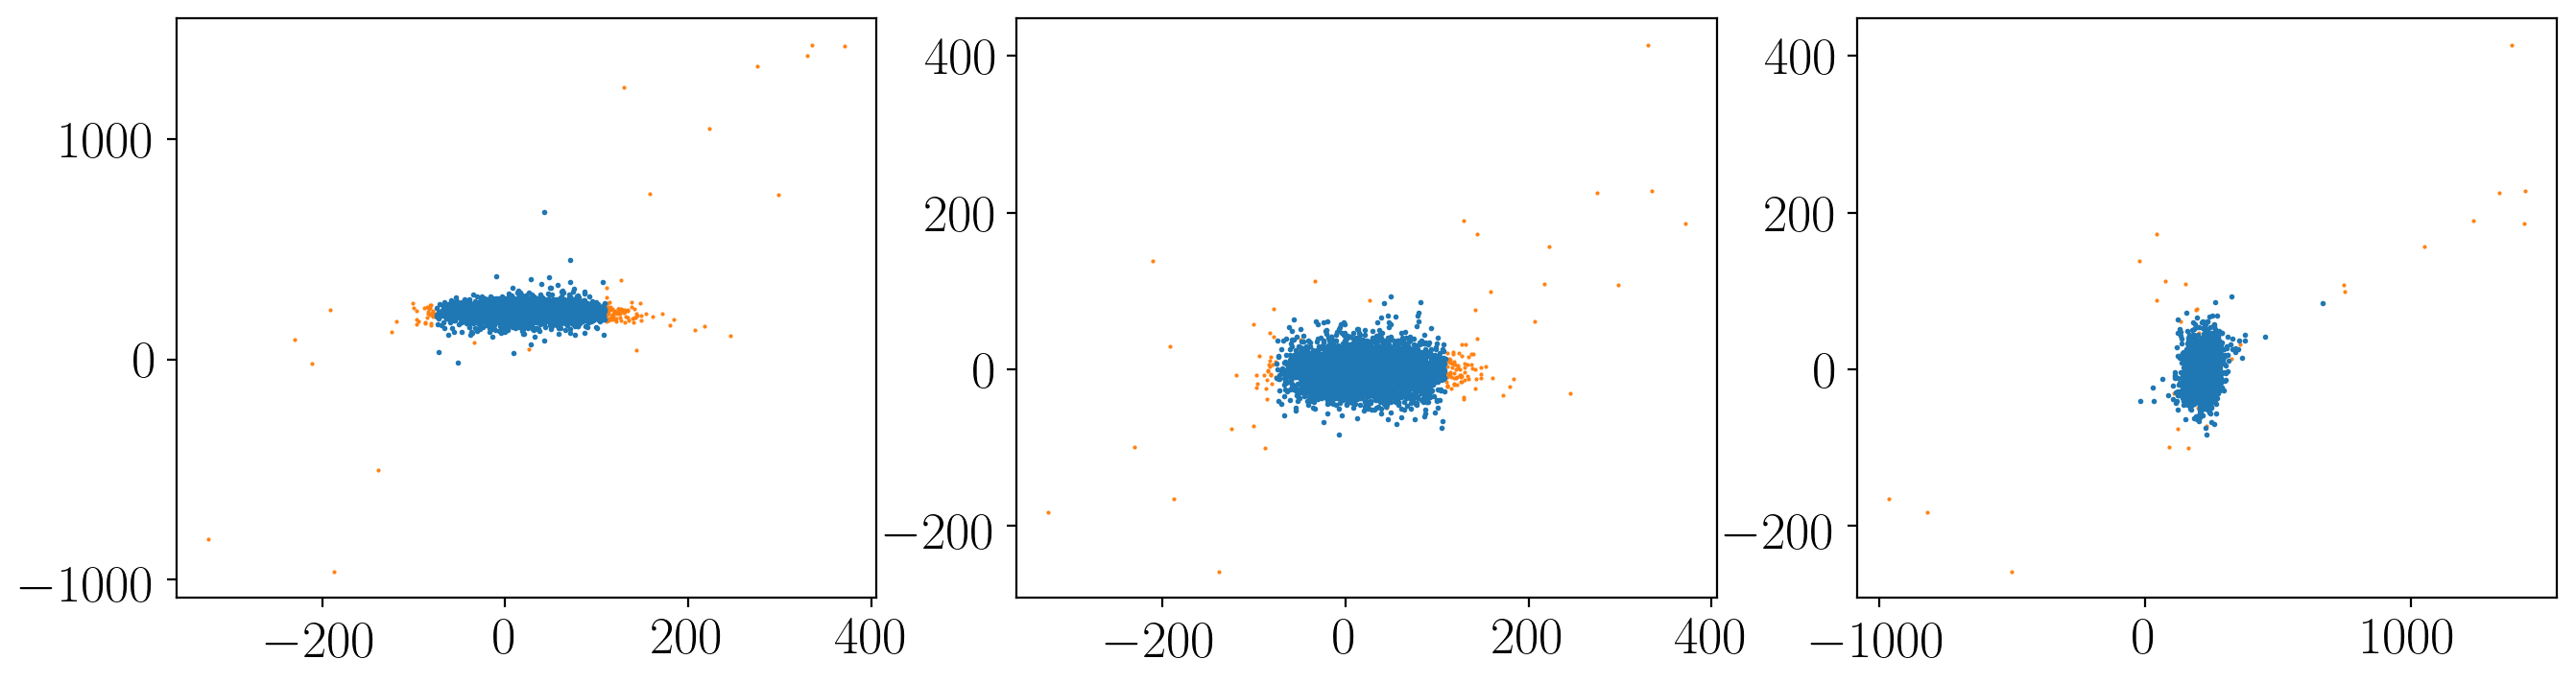

In [22]:
fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(vx, vy, "C1.", alpha=1, ms=1)
ax0.plot(vx_c, vy_c, "C0.", alpha=1, ms=2)
ax1 = fig.add_subplot(132)
ax1.plot(vx, vz, "C1.", alpha=1, ms=1)
ax1.plot(vx_c, vz_c, "C0.", alpha=1, ms=2)
ax2 = fig.add_subplot(133)
ax2.plot(vy, vz, "C1.", alpha=1, ms=1)
ax2.plot(vy_c, vz_c, "C0.", alpha=1, ms=2)

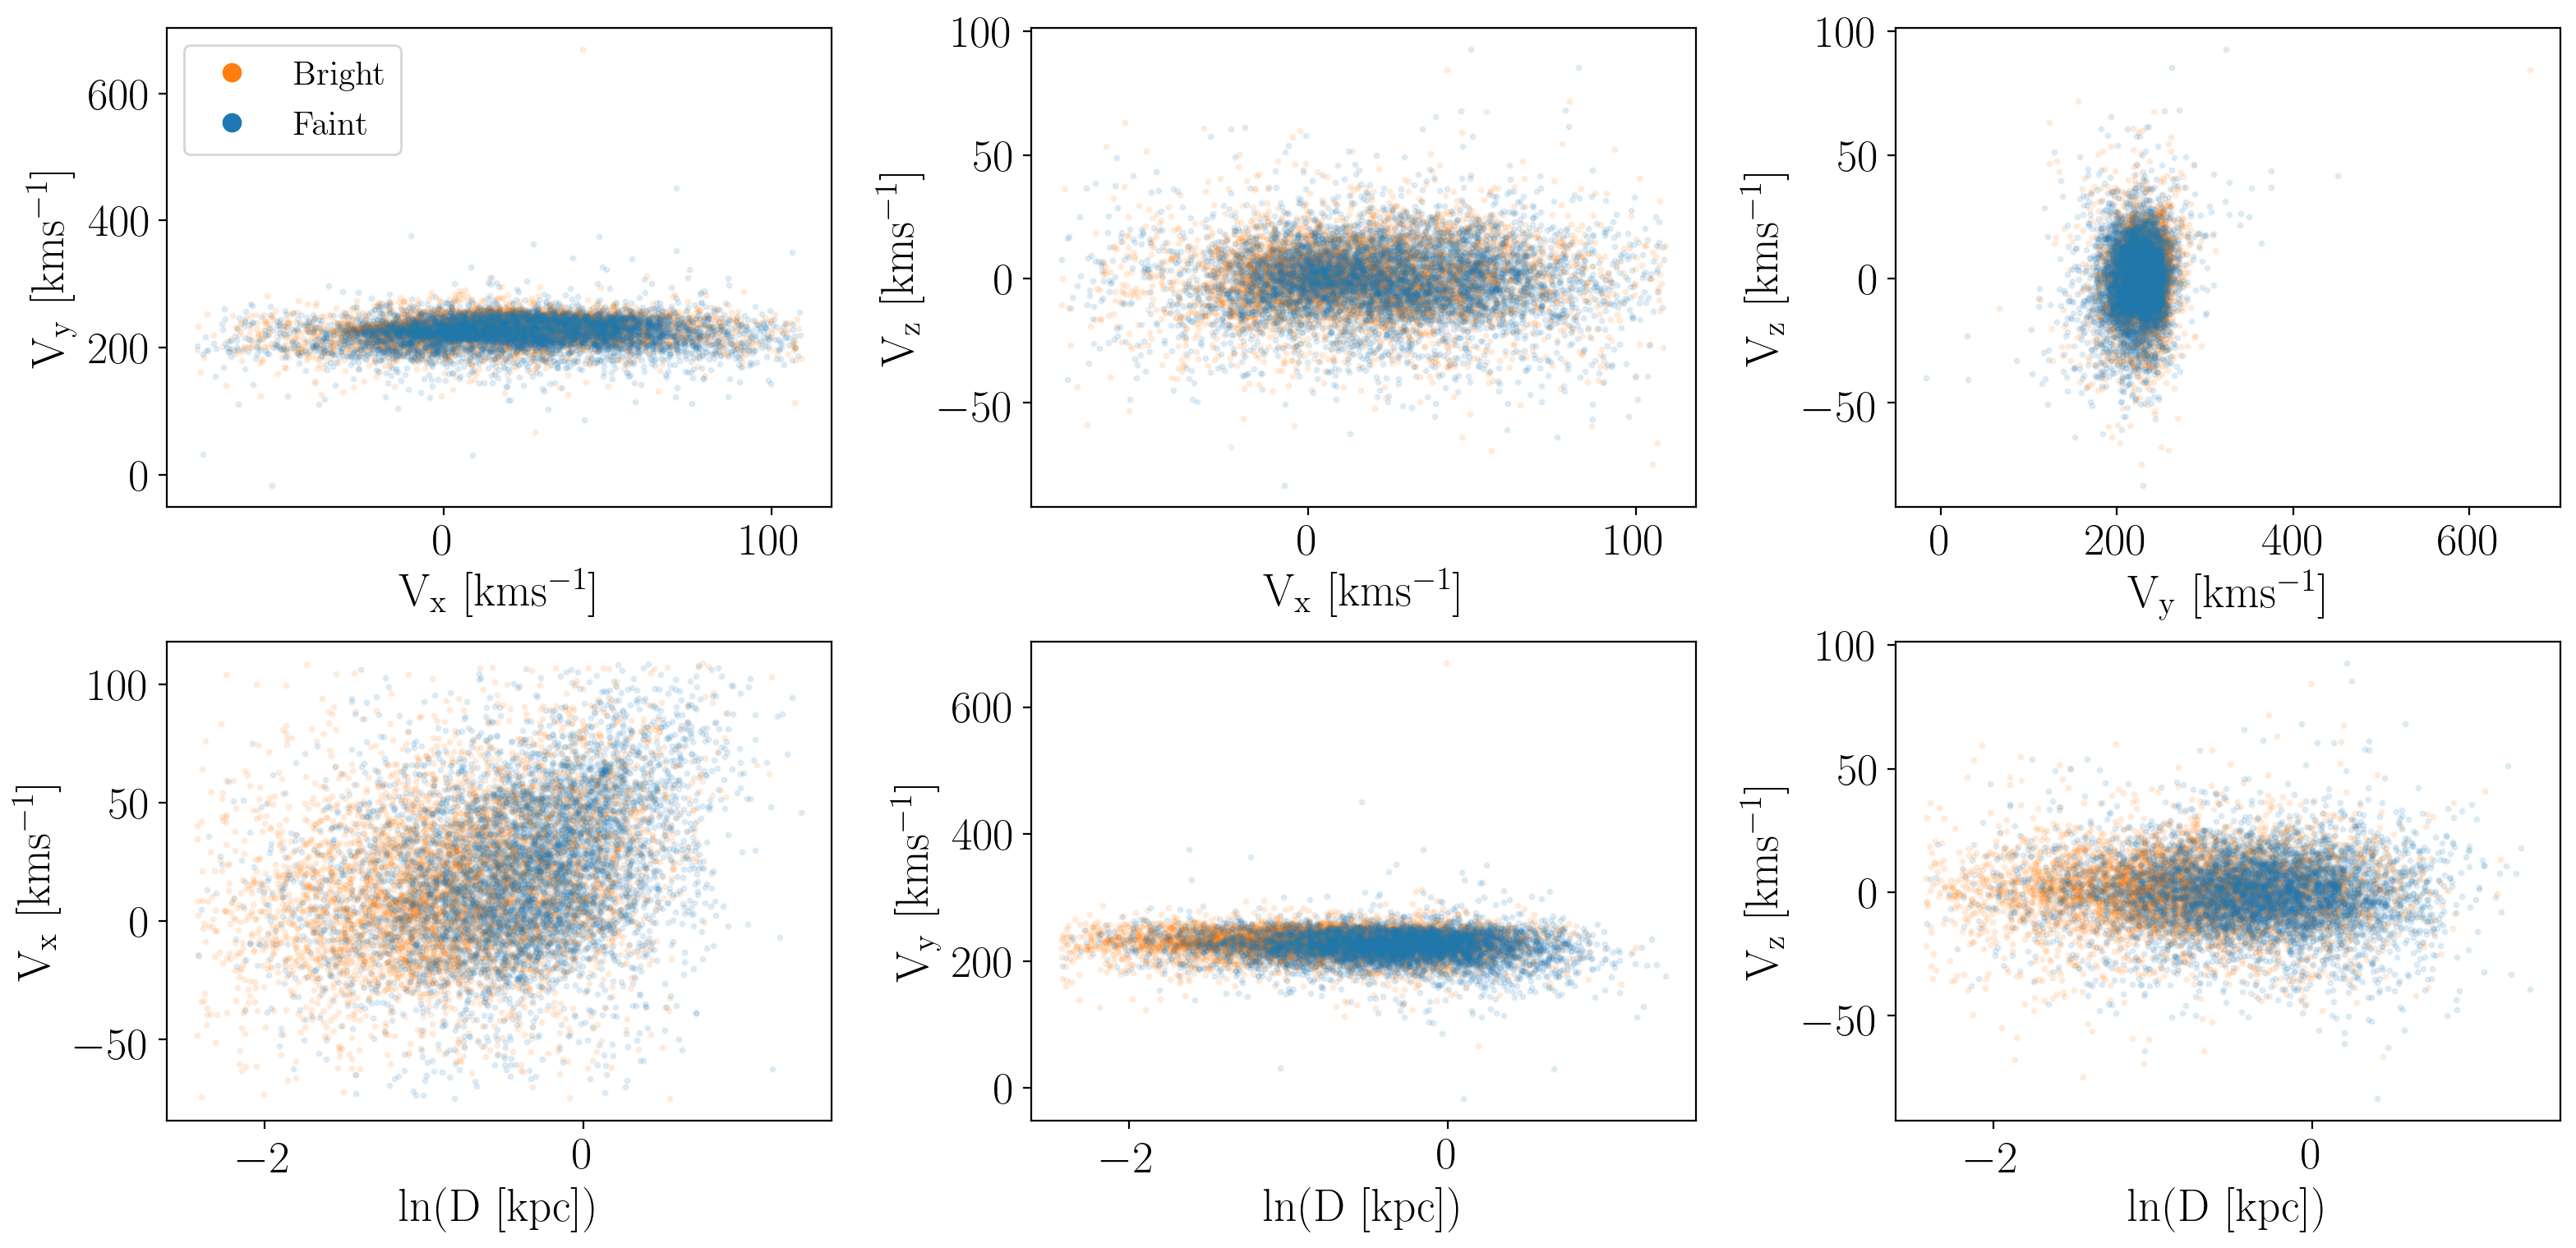

In [23]:
alpha, ms = .1, 4

b = g < 13.56
f = g > 13.56

fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.plot(vx_c[b], vy_c[b], "C1.", alpha=alpha, ms=ms, rasterized=True, label="$\mathrm{Bright}$")
ax0.plot(vx_c[f], vy_c[f], "C0.", alpha=alpha, ms=ms, rasterized=True, label="$\mathrm{Faint}$")
# ax0.set_xlim(xlim)
# ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
leg = ax0.legend()
leg.legendHandles[0]._legmarker.set_markersize(15)
leg.legendHandles[1]._legmarker.set_markersize(15)
leg.legendHandles[0]._legmarker.set_alpha(1)
leg.legendHandles[1]._legmarker.set_alpha(1)

ax1 = fig.add_subplot(232)
ax1.plot(vx_c[b], vz_c[b], "C1.", alpha=alpha, ms=ms, rasterized=True)
ax1.plot(vx_c[f], vz_c[f], "C0.", alpha=alpha, ms=ms, rasterized=True)
# ax1.set_xlim(xlim)
# ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.plot(vy_c[b], vz_c[b], "C1.", alpha=alpha, ms=ms, rasterized=True)
ax2.plot(vy_c[f], vz_c[f], "C0.", alpha=alpha, ms=ms, rasterized=True)
# ax2.set_xlim(ylim)
# ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")



ax3 = fig.add_subplot(234)
ax3.plot(lnD_c[b], vx_c[b], "C1.", alpha=alpha, ms=ms, rasterized=True)
ax3.plot(lnD_c[f], vx_c[f], "C0.", alpha=alpha, ms=ms, rasterized=True)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D~[kpc])}$")

ax4 = fig.add_subplot(235)
ax4.plot(lnD_c[b], vy_c[b], "C1.", alpha=alpha, ms=ms, rasterized=True)
ax4.plot(lnD_c[f], vy_c[f], "C0.", alpha=alpha, ms=ms, rasterized=True)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
# ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.plot(lnD_c[b], vz_c[b], "C1.", alpha=alpha, ms=ms, rasterized=True)
ax5.plot(lnD_c[f], vz_c[f], "C0.", alpha=alpha, ms=ms, rasterized=True)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
# ax5.set_ylim(zlim)

plt.tight_layout()
plt.subplots_adjust(hspace=.28)
plt.savefig("brightness_distributions")

In [24]:
import astropy.stats as aps

print(np.std(vz_c[f]), np.std(vz_c[b]), np.std(vz_c))
print(np.std(vz_c[f]) - np.std(vz_c[b]))
print(1.5*aps.median_absolute_deviation(vz_c[f]), 1.5*aps.median_absolute_deviation(vz_c[b]), 1.5*aps.median_absolute_deviation(vz_c))
print(1.5*aps.median_absolute_deviation(vz_c[f]) - 1.5*aps.median_absolute_deviation(vz_c[b]))

14.746065442236974 13.553185453376141 14.171910264116613
1.1928799888608328
12.749946190752505 11.689605550490045 12.238419230720567
1.06034064026246


In [25]:
def mean_and_var(vx, vy, vz, lnD):
    V = np.stack((vx, vy, vz, lnD), axis=0)
    return np.mean(V, axis=1), np.cov(V)

mu_faint, cov_faint = mean_and_var(vx[finite][m][f], vy[finite][m][f], vz[finite][m][f], lnD[finite][m][f])
mu_bright, cov_bright = mean_and_var(vx[finite][m][b], vy[finite][m][b], vz[finite][m][b], lnD[finite][m][b])
mu_all, cov_all = mean_and_var(vx[finite][m], vy[finite][m], vz[finite][m], lnD[finite][m])

Code for plotting a confidence ellipse, from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

In [26]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse_mod(x, y, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Plot prior distributions.

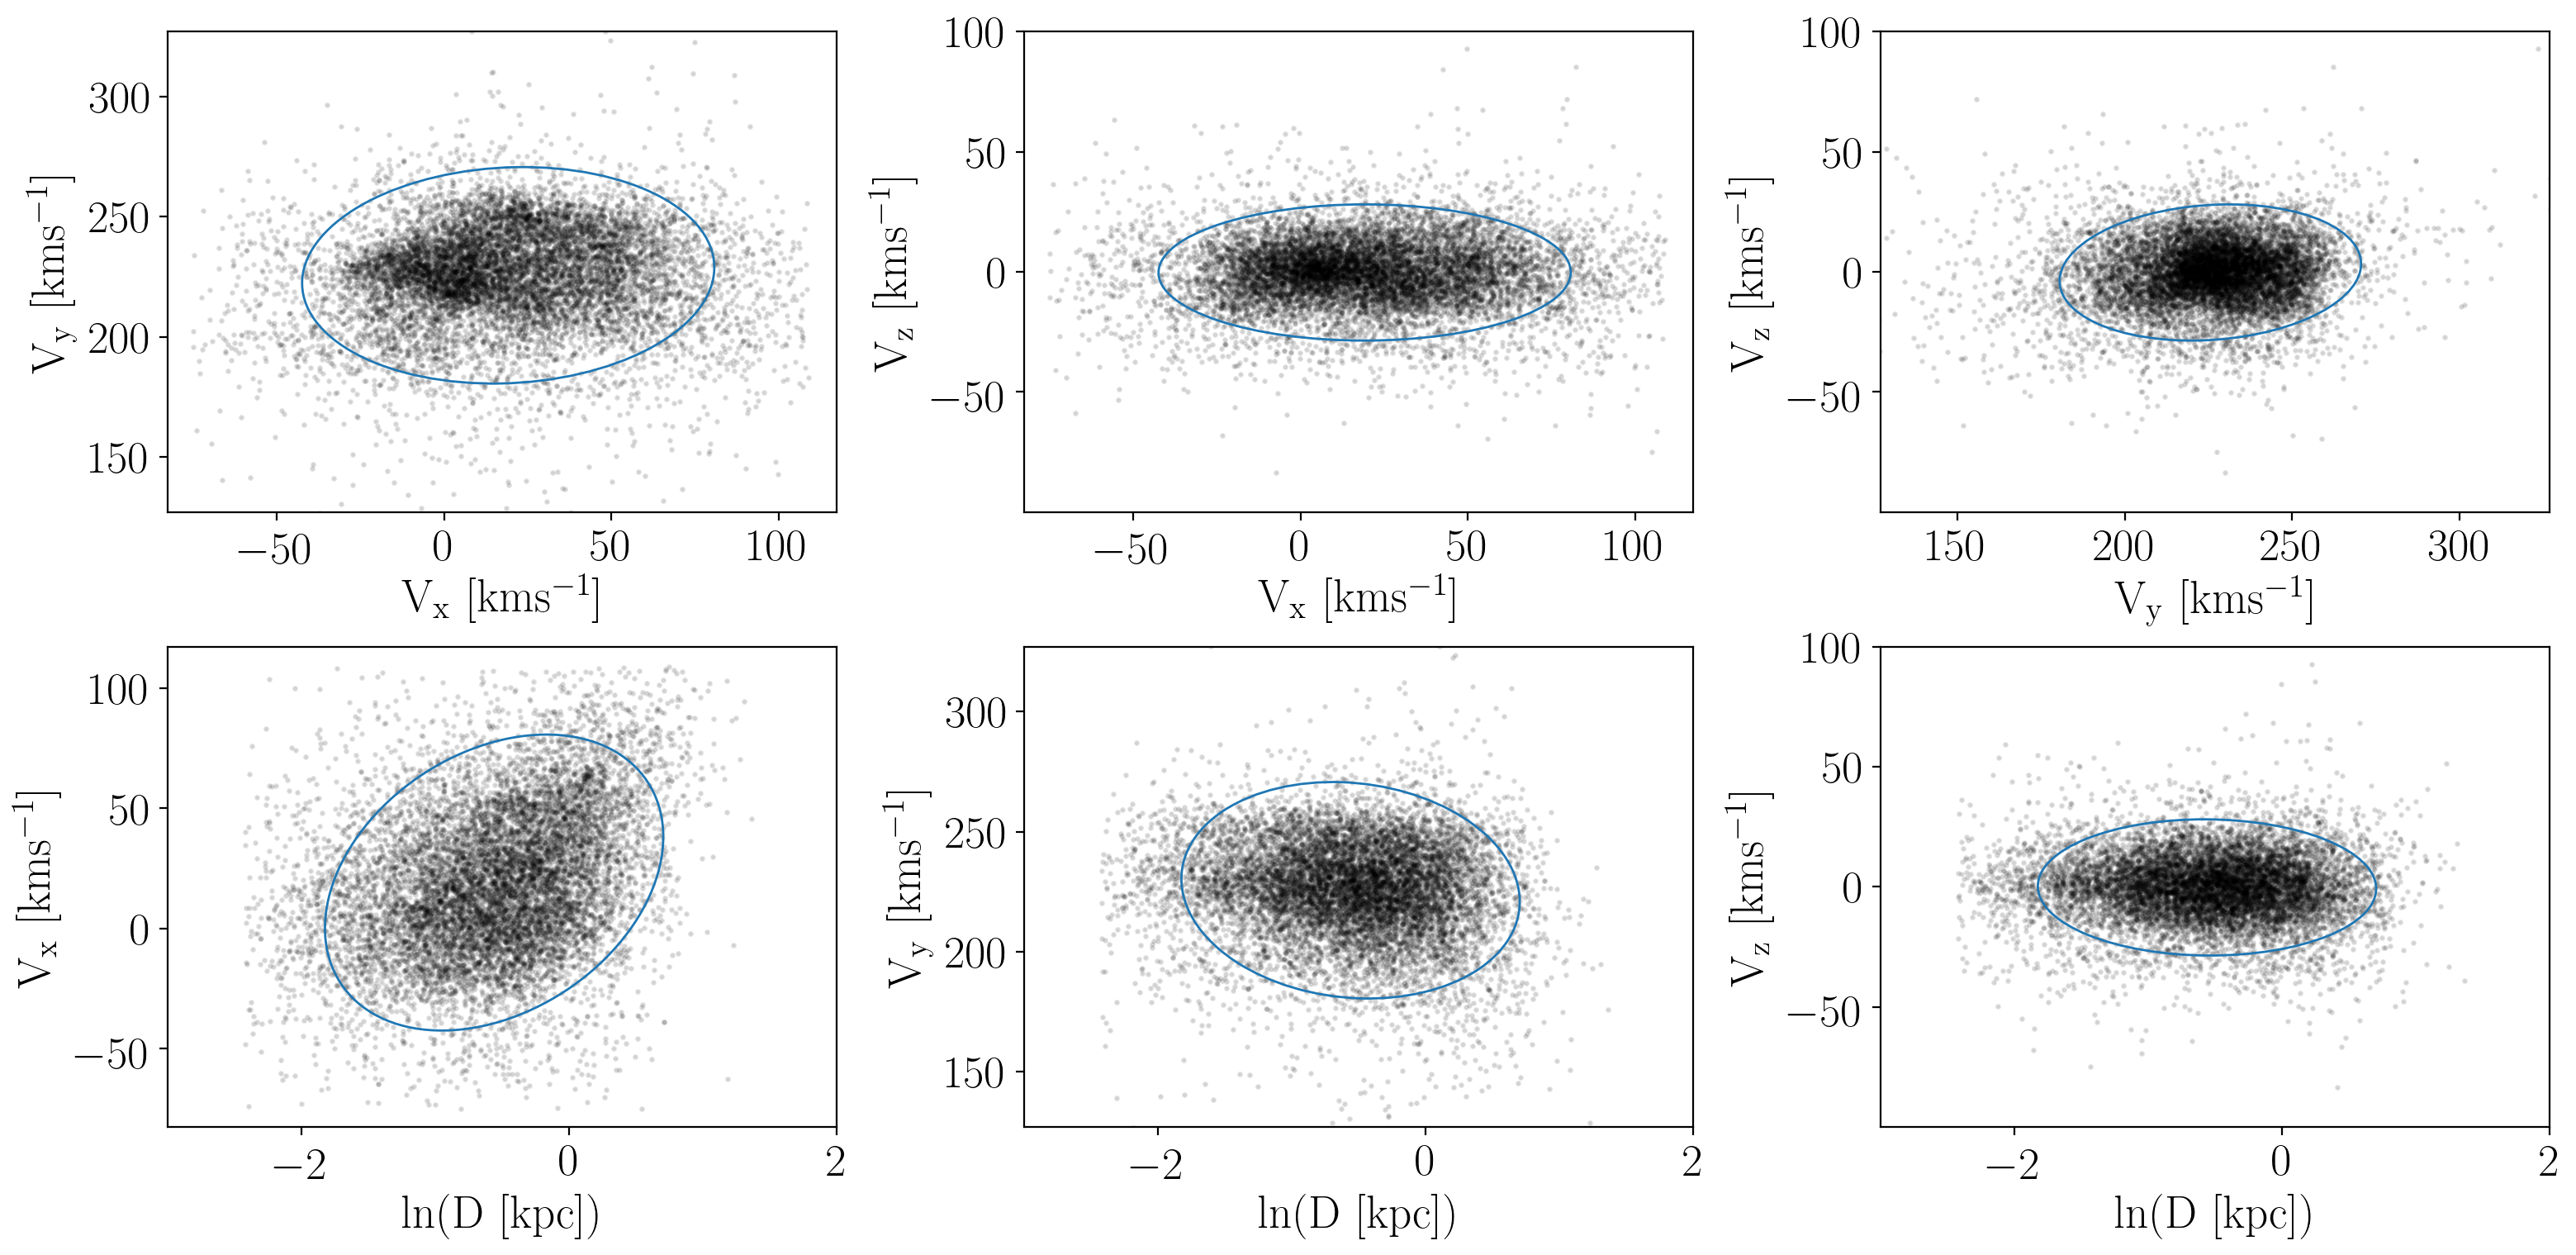

In [27]:
alpha, ms = .1, 3

box = 100
medx, medy, medz = np.median(vx_c), np.median(vy_c), np.median(vz_c)
xlim, ylim, zlim, dlim = (medx-box, medx+box), (medy-box, medy+box), (medz-box, medz+box), (-3, 2)

fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.plot(vx_c, vy_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
cov = np.array([[cov_all[0, 0], cov_all[0, 1]], [cov_all[1, 0], cov_all[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, cov, ax0, n_std=2, edgecolor='C0', zorder=1)
# xs = np.linspace(xlim[0], xlim[1], 100)
# ax0.plot(xs, np.polyval(np.polyfit(vx_c, vy_c, 1), xs)) 
# plt.plot(xs, np.sqrt(cov_all[0, 1])*xs)
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

ax1 = fig.add_subplot(232)
ax1.plot(vx_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
cov = np.array([[cov_all[0, 0], cov_all[0, 2]], [cov_all[2, 0], cov_all[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, cov, ax1, n_std=2, edgecolor='C0', zorder=1)
# ax1.plot(xs, np.polyval(np.polyfit(vx_c, vz_c, 1), xs)) 
ax1.set_xlim(xlim)
ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.plot(vy_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
cov = np.array([[cov_all[1, 1], cov_all[1, 2]], [cov_all[2, 1], cov_all[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, cov, ax2, n_std=2, edgecolor='C0', zorder=1)
# xs = np.linspace(ylim[0], ylim[1], 100)
# ax2.plot(xs, np.polyval(np.polyfit(vy_c, vz_c, 1), xs)) 
ax2.set_xlim(ylim)
ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")


ax3 = fig.add_subplot(234)
ax3.plot(lnD_c, vx_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
cov = np.array([[cov_all[3, 3], cov_all[3, 0]], [cov_all[0, 3], cov_all[0, 0]]])
confidence_ellipse_mod(lnD_c, vx_c, cov, ax3, n_std=2, edgecolor='C0', zorder=1)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax3.set_xlim(dlim)
ax3.set_ylim(xlim)

ax4 = fig.add_subplot(235)
ax4.plot(lnD_c, vy_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
cov = np.array([[cov_all[3, 3], cov_all[3, 1]], [cov_all[1, 3], cov_all[1, 1]]])
confidence_ellipse_mod(lnD_c, vy_c, cov, ax4, n_std=2, edgecolor='C0', zorder=1)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax4.set_xlim(dlim)
ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.plot(lnD_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
cov = np.array([[cov_all[3, 3], cov_all[3, 2]], [cov_all[2, 3], cov_all[2, 2]]])
confidence_ellipse_mod(lnD_c, vz_c, cov, ax5, n_std=2, edgecolor='C0', zorder=1)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax5.set_xlim(dlim)
ax5.set_ylim(zlim)

plt.tight_layout()
plt.subplots_adjust(hspace=.28, wspace=.28)
plt.savefig("../../paper/prior_distributions_2D.pdf")
plt.savefig("prior_distributions_2D")

In [28]:
def gauss(x, mu, sig):
    return 1./(sig * np.sqrt(2 * np.pi)) * np.exp(-.5 * (x - mu)**2 / sig**2)

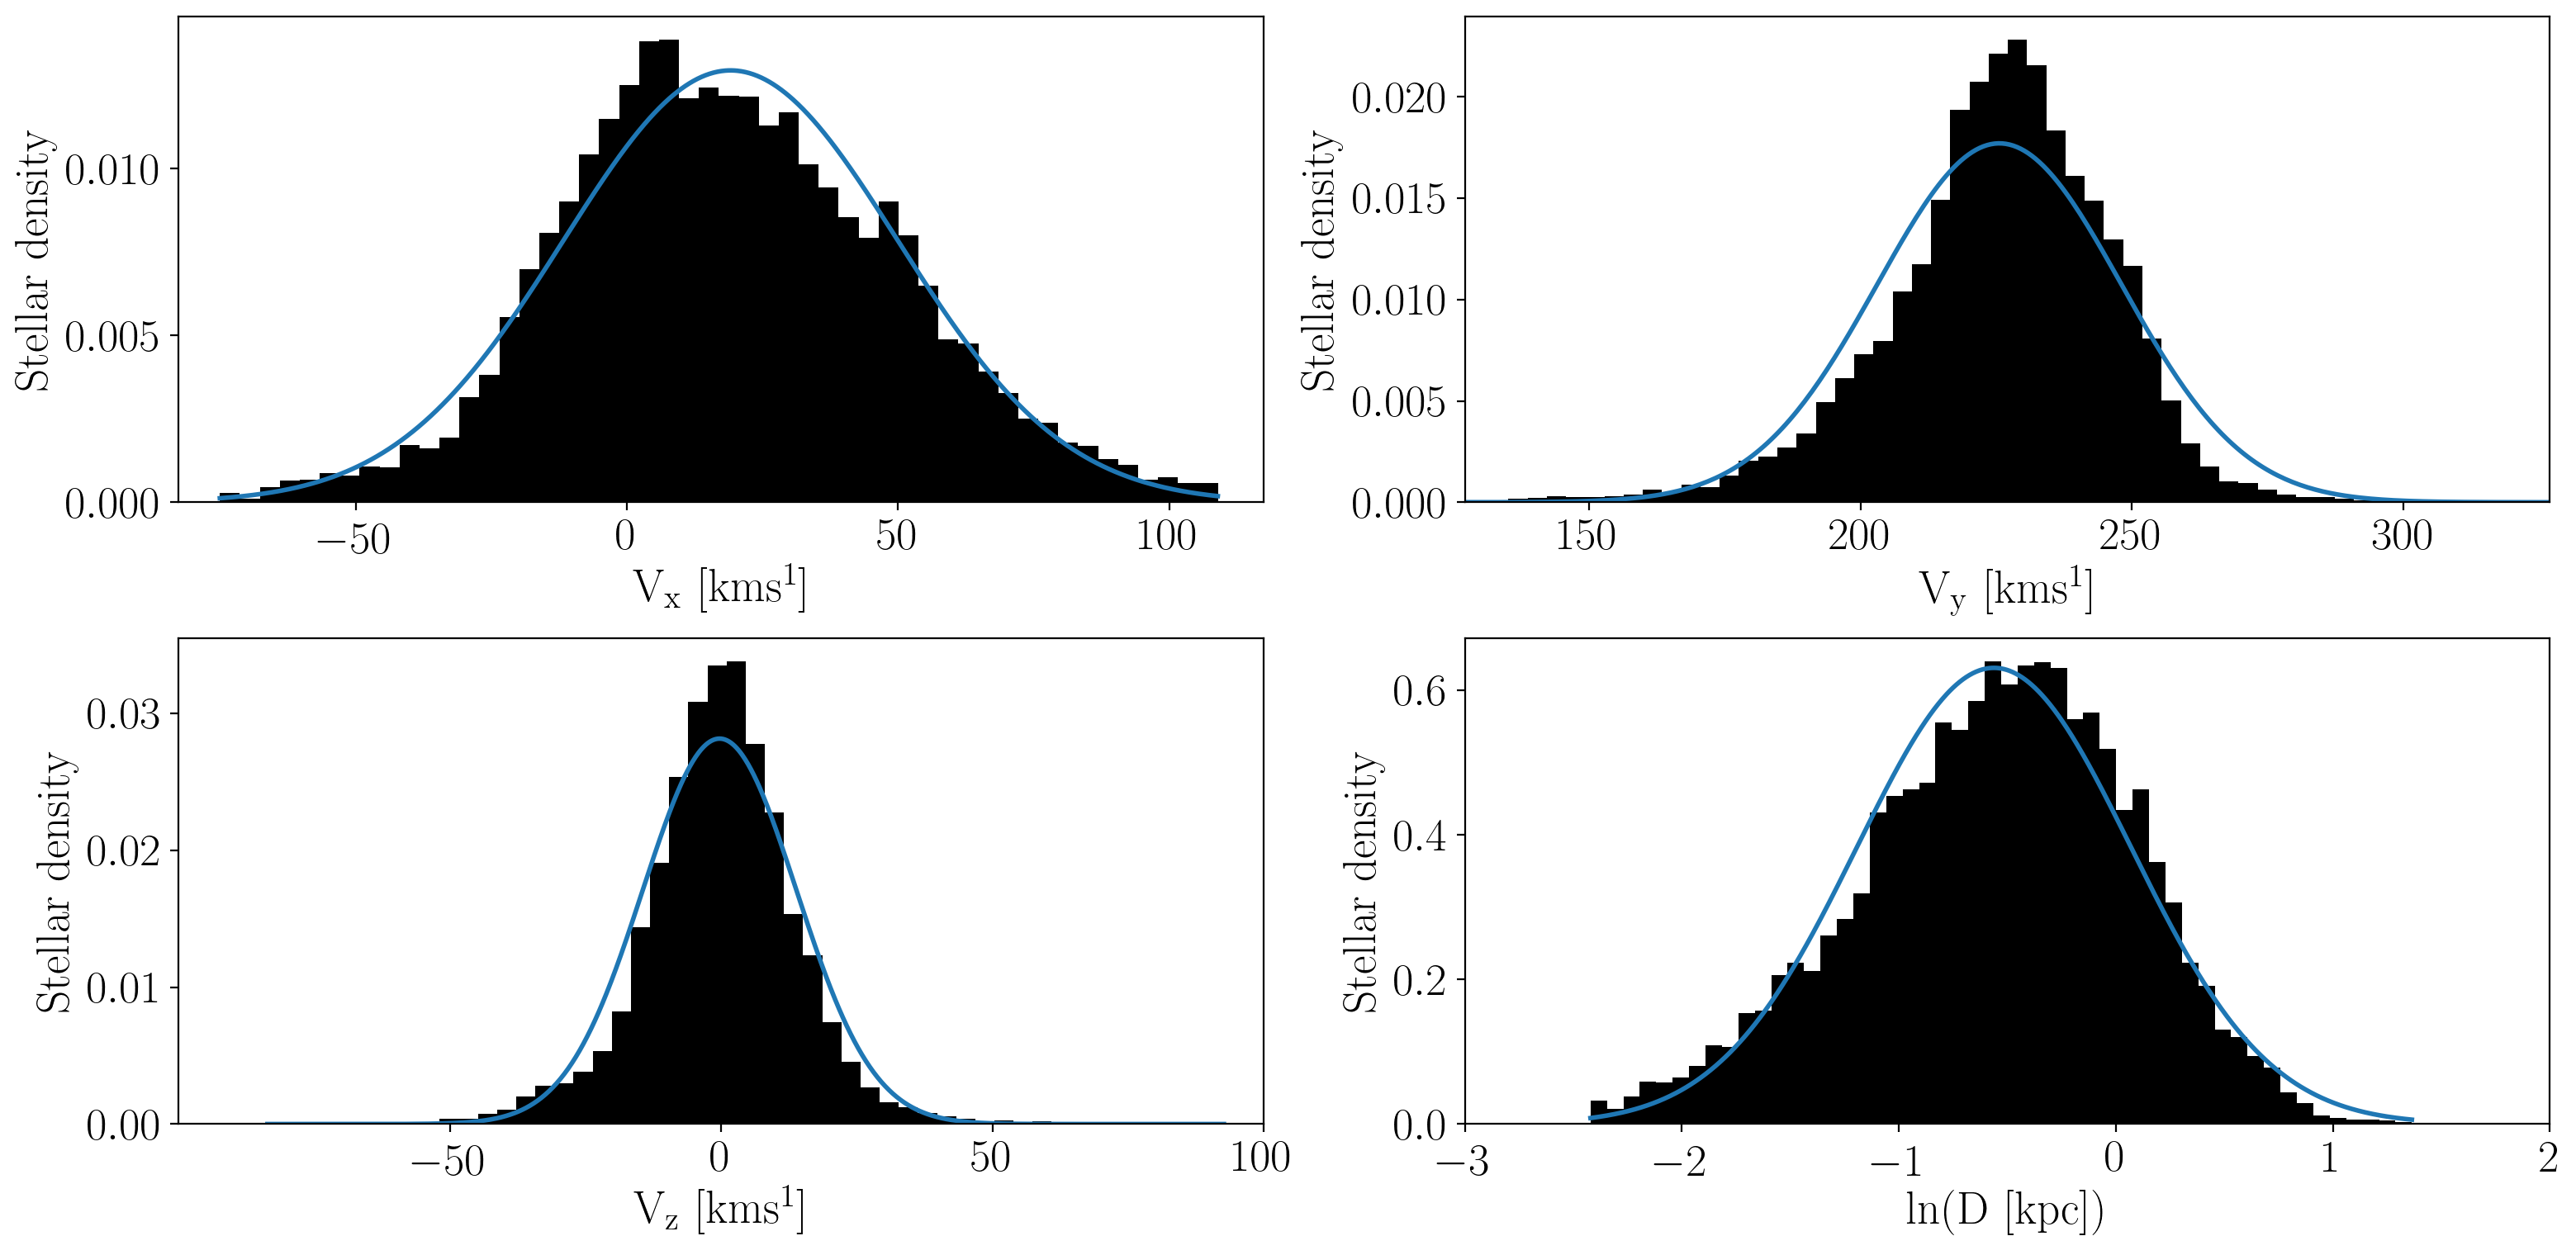

In [29]:
fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(221)
ax0.hist(vx_c, 50, color="k", density=True);
xs = np.linspace(min(vx_c), max(vx_c), 1000)
# ax0.plot(xs, gauss(xs, mu_all[0], np.sqrt(cov_all[0, 0])), color="k", lw=3, rasterized=True)
ax0.plot(xs, gauss(xs, mu_all[0], np.sqrt(cov_all[0, 0])), color="C0", lw=2, rasterized=True)
ax0.set_xlabel("$\mathrm{V_x~[kms{^1}]}$")
# ax0.set_yticklabels([])
ax0.set_ylabel("$\mathrm{Stellar~density}$")
ax0.set_xlim(xlim)

ax1 = fig.add_subplot(222)
m_ = (120 < vy_c) & (vy_c < 300)
ax1.hist(vy_c[m_], 50, color="k", density=True);
xs = np.linspace(min(vy_c), max(vy_c), 1000)
# ax1.plot(xs, gauss(xs, mu_all[1], np.sqrt(cov_all[1, 1])), color="k", lw=3, rasterized=True)
ax1.plot(xs, gauss(xs, mu_all[1], np.sqrt(cov_all[1, 1])), color="C0", lw=2, rasterized=True)
ax1.set_xlabel("$\mathrm{V_y~[kms{^1}]}$")
ax1.set_xlim(200, 280)
# ax1.set_yticklabels([])
ax1.set_ylabel("$\mathrm{Stellar~density}$")
ax1.set_xlim(ylim)

ax2 = fig.add_subplot(223)
m_ = (zlim[0] < vz_c) & (vz_c < zlim[1])
ax2.hist(vz_c[m_], 50, color="k", density=True);
xs = np.linspace(min(vz_c), max(vz_c), 1000)
# ax2.plot(xs, gauss(xs, mu_all[2], np.sqrt(cov_all[2, 2])), color="k", lw=3, rasterized=True)
ax2.plot(xs, gauss(xs, mu_all[2], np.sqrt(cov_all[2, 2])), color="C0", lw=2, rasterized=True)
ax2.set_xlabel("$\mathrm{V_z~[kms{^1}]}$")
ax2.set_xlim(-50, 50)
# ax2.set_yticklabels([])
ax2.set_ylabel("$\mathrm{Stellar~density}$")
ax2.set_xlim(zlim)

ax3 = fig.add_subplot(224)
ax3.hist(lnD_c, 50, color="k", density=True);
xs = np.linspace(min(lnD_c), max(lnD_c), 1000)
# ax3.plot(xs, gauss(xs, mu_all[3], np.sqrt(cov_all[3, 3])), color="k", lw=3, rasterized=True)
ax3.plot(xs, gauss(xs, mu_all[3], np.sqrt(cov_all[3, 3])), color="C0", lw=2, rasterized=True)
ax3.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
# ax3.set_yticklabels([])
ax3.set_ylabel("$\mathrm{Stellar~density}$")
ax3.set_xlim(dlim)

plt.tight_layout()
plt.subplots_adjust(hspace=.28)
plt.savefig("../../paper/prior_distributions.pdf")
plt.savefig("prior_distributions")

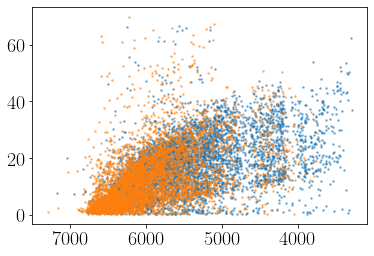

In [30]:
fig = plt.figure()
ax0 = fig.add_subplot(111)
ax0.plot(df.teff.values[finite][m][f], df.Prot.values[finite][m][f], ".", ms=3, alpha=.5)
ax0.plot(df.teff.values[finite][m][b], df.Prot.values[finite][m][b], ".", ms=3, alpha=.5)
ax0.invert_xaxis()

In [32]:
print(np.median(g))

13.558509826660154


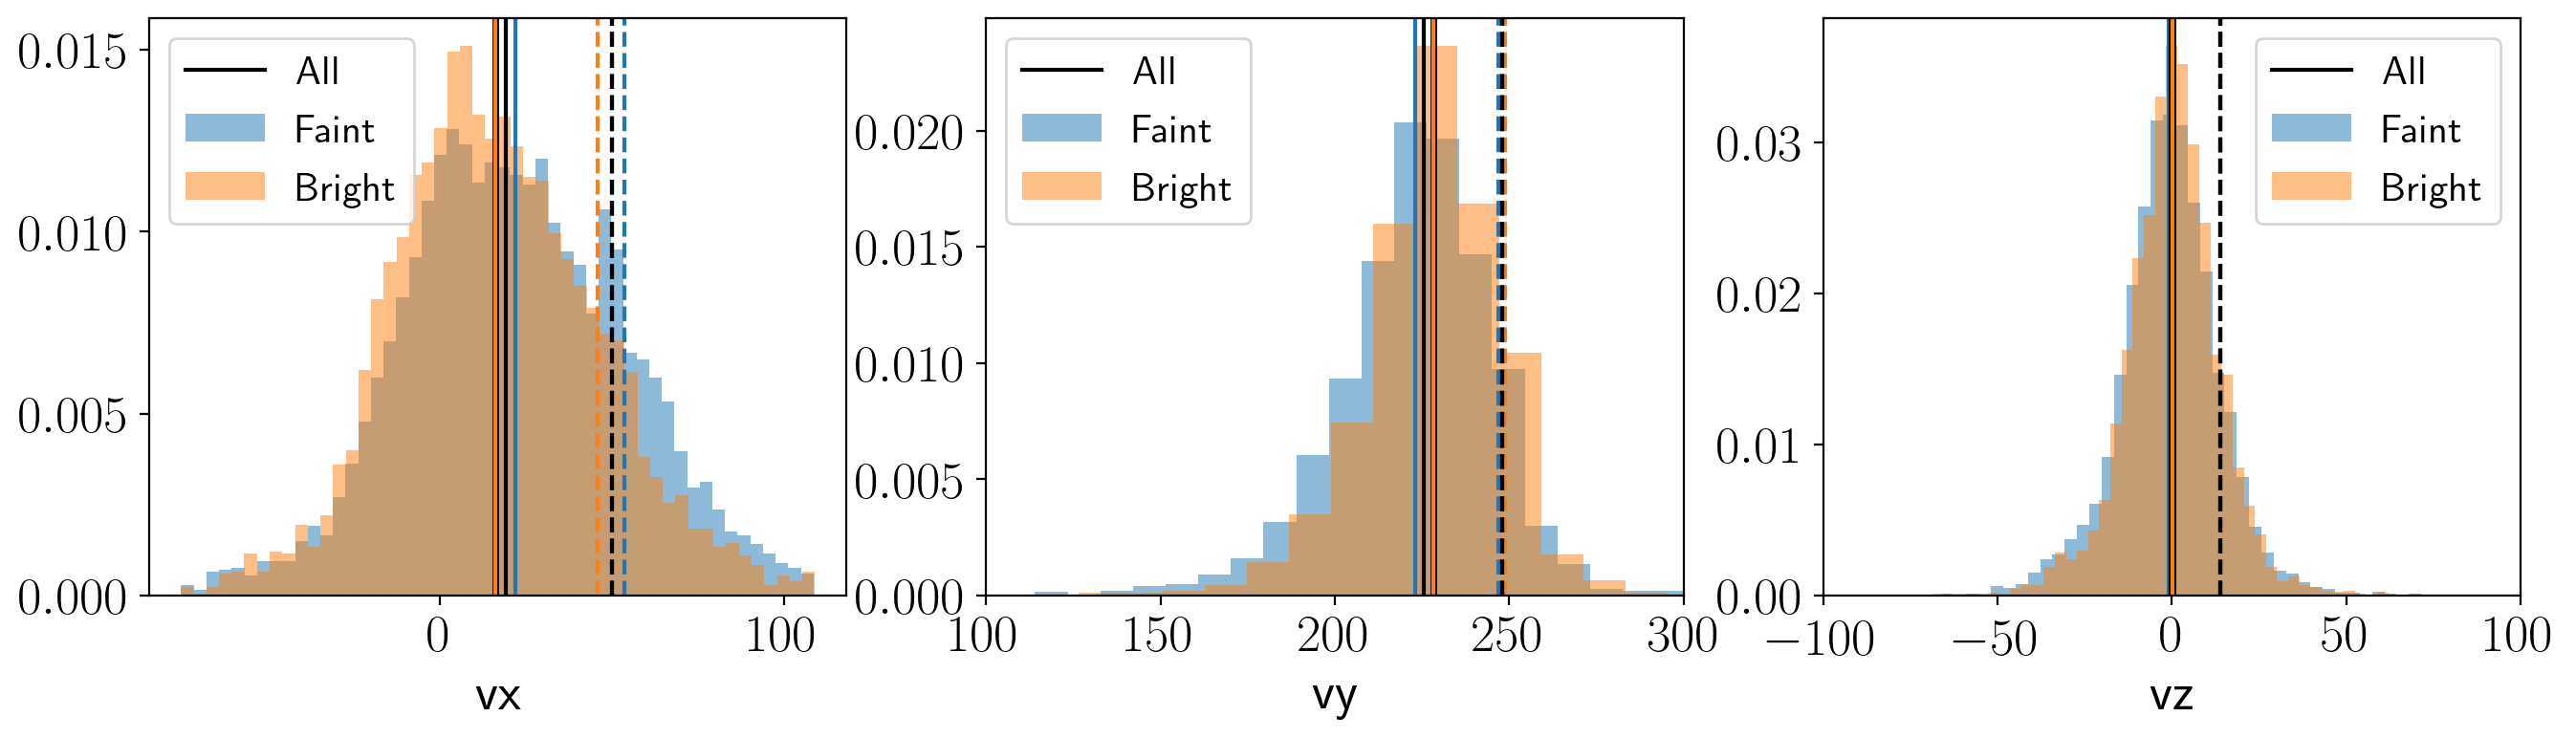

In [33]:
fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.hist(vx[finite][m][f], 50, density=True, alpha=.5, label="Faint");
ax0.hist(vx[finite][m][b], 50, density=True, alpha=.5, label="Bright");
ax0.axvline(np.mean(vx[finite][m][f]), color="C0")
ax0.axvline(np.mean(vx[finite][m]), color="k", label="All")
ax0.axvline(np.mean(vx[finite][m][b]), color="k", lw=2.5)
ax0.axvline(np.mean(vx[finite][m][b]), color="C1")
ax0.axvline(np.mean(vx[finite][m][b]) + np.sqrt(cov_bright[0, 0]), color="C1", ls="--")
ax0.axvline(np.mean(vx[finite][m][f]) + np.sqrt(cov_faint[0, 0]), color="C0", ls="--")
ax0.axvline(np.mean(vx[finite][m]) + np.sqrt(cov_all[0, 0]), color="k", ls="--")
ax0.axvline(np.mean(vx[finite][m]) + np.sqrt(cov_all[0, 0]), color="k", ls="--")
ax0.legend()
ax0.set_xlabel("vx")

ax1 = fig.add_subplot(132)
ax1.hist(vy[finite][m][f], 50, density=True, alpha=.5, label="Faint");
ax1.hist(vy[finite][m][b], 50, density=True, alpha=.5, label="Bright");
ax1.axvline(np.mean(vy[finite][m][f]), color="C0")
ax1.axvline(np.mean(vy[finite][m]), color="k", label="All")
ax1.axvline(np.mean(vy[finite][m][b]), color="k", lw=2.5)
ax1.axvline(np.mean(vy[finite][m][b]), color="C1")
ax1.axvline(np.mean(vy[finite][m][b]) + np.sqrt(cov_bright[1, 1]), color="C1", ls="--")
ax1.axvline(np.mean(vy[finite][m][f]) + np.sqrt(cov_faint[1, 1]), color="C0", ls="--")
ax1.axvline(np.mean(vy[finite][m]) + np.sqrt(cov_all[1, 1]), color="k", ls="--")
ax1.axvline(np.mean(vy[finite][m]) + np.sqrt(cov_all[1, 1]), color="k", ls="--")
ax1.legend()
ax1.set_xlabel("vy")
ax1.set_xlim(100, 300)

ax2 = fig.add_subplot(133)
ax2.hist(vz[finite][m][f], 50, density=True, alpha=.5, label="Faint");
ax2.hist(vz[finite][m][b], 50, density=True, alpha=.5, label="Bright");
ax2.axvline(np.mean(vz[finite][m][m_faint]), color="C0")
ax2.axvline(np.mean(vz[finite][m]), color="k", label="All")
ax2.axvline(np.mean(vz[finite][m][b]), color="k", lw=2.5)
ax2.axvline(np.mean(vz[finite][m][b]), color="C1")
ax2.axvline(np.mean(vz[finite][m][b]) + np.sqrt(cov_bright[2, 2]), color="C1", ls="--")
ax2.axvline(np.mean(vz[finite][m][f]) + np.sqrt(cov_faint[2, 2]), color="C0", ls="--")
ax2.axvline(np.mean(vz[finite][m]) + np.sqrt(cov_all[2, 2]), color="k", ls="--")
ax2.axvline(np.mean(vz[finite][m]) + np.sqrt(cov_all[2, 2]), color="k", ls="--")
ax2.legend()
ax2.set_xlabel("vz")
ax2.set_xlim(-100, 100);